In [1]:
import set_path

import numpy as np
import laspy
import geopandas as gpd

import open3d as o3d

from upcp.utils import ahn_utils, clip_utils
from upcp.utils.interpolation import FastGridInterpolator

from gvl.helper_functions import color_clusters
from gvl.tree_detector import DetectorTree
from gvl.ahn_utils import GeoTIFFReader2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import warnings  # temporary, to supress deprecationwarnings from shapely
warnings.filterwarnings('ignore')

In [3]:
RD_CRS = 'epsg:28992'
LL_CRS = 'WGS84'

# AHN classification
AHN_OTHER = 1
AHN_GROUND = 2
AHN_BUILDING = 6
AHN_WATER = 9
AHN_ARTIFACT = 26

In [4]:
# # Use CycloMedia style tilecodes
# tilecode = '2463_9714'

# las_file = f'../datasets/ahn_{tilecode}.laz'
# ahn_npz_folder = '../../../datasets/Accessibility_oost/ahn/ahn4_npz/'

# ahn_reader = ahn_utils.NPZReader(ahn_npz_folder, caching=False)

### TODO make geotiles scraper
We use 5m resolution. The ground filter improvements when using is 0.5m is negligible and running time increases.

In [5]:
# Use AHN subtiles
tilecode = '25GN1_04'

las_file = f'../datasets/ahn_laz/{tilecode}.LAZ'
ahn_geotiff_folder = '../datasets/ahn_dtm/'

ahn_reader = GeoTIFFReader2(ahn_geotiff_folder, fill_gaps=False,
                            smoothen=True, smooth_thickness=2)

In [6]:
target_area = gpd.read_file(f'../datasets/validation/correct_trees_areas_oosterpark.shp', crs=RD_CRS)
one_poly = target_area['geometry'].iloc[1]

In [7]:
bbox = target_area.unary_union.bounds
#bbox = one_poly.bounds

In [8]:
target_area_points = gpd.read_file(f'../datasets/validation/correct_trees_oosterpark.shp', crs=RD_CRS)


In [9]:
target_area_points = target_area_points.to_crs(RD_CRS)

In [10]:
jm = target_area.head(2).tail(1)

In [11]:
from shapely.geometry import Point, Polygon

listje = []
for point in list(target_area_points['geometry'].values):
    poly = Polygon(jm['geometry'].values[0])
    if jm['geometry'].values[0].intersects(point):
        listje.append(point)

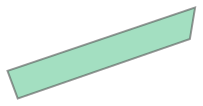

In [12]:
jm['geometry'].values[0]

In [13]:
import pandas as pd
df = pd.DataFrame(listje)

In [14]:
df = df.rename(columns={0: "geometry"})

In [15]:
gp_df = gpd.GeoDataFrame(df, crs=RD_CRS)

In [16]:
df['bgt_type'] = 'boom'
df['X'] = gp_df['geometry'].x
df['Y'] = gp_df['geometry'].y
df = df.drop('geometry', 1)


In [17]:
df.to_csv('custom_poles_demo.csv', index=False)

In [18]:
gp_df.to_file("one_geometry_points.shp")

In [19]:
jm.to_file("one_geometry.shp")

In [20]:
las = laspy.read(las_file)
pts = np.vstack((las.x, las.y, las.z)).T

### Filter 1: scalar fields and clip
- classification -> 'overig label' points

We dont want to filter in the number_of_returns scalar field. It will remove too much valuable tree points. 

In [21]:
area_mask = clip_utils.rectangle_clip(pts, bbox)
class_mask = las.classification == AHN_OTHER

mask = class_mask & area_mask

In [22]:
points_dtype = np.dtype([('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'),
                         ('NZ', '<f8'), ('HAG', '<f8'),
                         ('Classification', '<i4'), ('NumberOfReturns', '<i4'), ('ReturnNumber', '<i4')])
points = np.empty(shape=(np.count_nonzero(mask),), dtype=points_dtype)

In [23]:
o3d_pc = o3d.geometry.PointCloud()
o3d_pc.points = o3d.utility.Vector3dVector(pts[mask])
o3d_pc.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                                                      max_nn=30))

In [24]:
gnd_tile = ahn_reader.filter_area(bbox)

fast_z = FastGridInterpolator(
            gnd_tile['x'], gnd_tile['y'], gnd_tile['ground_surface'])
gnd_z = fast_z(pts[mask])

In [25]:
np.count_nonzero(gnd_z == np.nan)

0

In [26]:
points['X'] = pts[mask,0]
points['Y'] = pts[mask,1]
points['Z'] = pts[mask,2]
points['NZ'] = np.asarray(o3d_pc.normals)[:,2]
points['HAG'] = pts[mask,2] - gnd_z
points['Classification'] = las.classification[mask] # TODO always AHN_OTHER
points['NumberOfReturns'] = las.number_of_returns[mask]
points['ReturnNumber'] = las.return_number[mask]

### Filter 2: points close to ground
TODO move this before the KDTree code

In [45]:
above_ground_in_meters = 2.5
raw_points = points[points['HAG'] >= above_ground_in_meters]

In [46]:
kk = list(zip(*raw_points))

points_3d = np.vstack((kk[0], kk[1], kk[2])).T
#points_3d = np.vstack((pts[mask,0], pts[mask,1], pts[mask,2])).T

### Filter 3: Noise filter
TODO create

# LCC

In [47]:
from upcp.utils.clip_utils import poly_box_clip
from upcp.utils.math_utils import minimum_bounding_rectangle

def _label_tree_like_components(points, point_components,
                               road_polygons, min_length):
    """ Based on certain properties of a tree we label clusters.  """
    
    # TODO add height info

    tree_mask = np.zeros(len(points), dtype=bool)
    tree_count = 0

    cc_labels = np.unique(point_components)

    cc_labels = set(cc_labels).difference((-1,))

    for cc in cc_labels:
        # select points that belong to the cluster
        cc_mask = (point_components == cc)

        valid_values = points[cc_mask]

        if valid_values.size != 0:
            cc_z = np.mean(valid_values)
            mbrect, conv_hull, mbr_width, mbr_length, _ =\
                minimum_bounding_rectangle(points[cc_mask][:, :2])
            p1 = Polygon(conv_hull)
            for p2 in road_polygons:
                do_overlap = p1.intersects(p2)
                if do_overlap:
                    tree_mask[cc_mask] = True
                    tree_count += 1
                    break

    print(f'{tree_count} tree labelled.')

    return tree_mask

In [48]:
tree_points = list(target_area_points['geometry'].values) # gp_df

In [49]:
from upcp.region_growing.label_connected_comp import LabelConnectedComp

label_mask = np.zeros((len(points_3d),), dtype=bool)

if len(tree_points) == 0:
    print('No reference tree points, skipping.')

label = 10
grid_size = 1.2
min_component_size = 50

min_length = 1

lcc = LabelConnectedComp(label, grid_size=grid_size,
                         min_component_size=min_component_size)
point_components = lcc.get_components(points_3d)

# Label tree like clusters
tree_mask = _label_tree_like_components(points_3d,
                                       point_components,
                                       tree_points, min_length)
label_mask = tree_mask

66 cars labelled.


In [50]:
header = laspy.LasHeader(point_format=3, version="1.2")
header.offsets = las.header.offsets
header.scales = las.header.scales

new_las = laspy.LasData(header)

new_las.x = points_3d[label_mask, 0]
new_las.y = points_3d[label_mask, 1]
new_las.z = points_3d[label_mask, 2]

new_las.write(f'trees_{tilecode}_2.laz')